In [1]:
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from boruta import BorutaPy
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import time
from shap_select import shap_select
import hisel
from shap_selection import feature_selection
from skfeature.function.information_theoretical_based import MRMR

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Global XGBoost parameters for consistency
XGB_PARAMS = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "verbosity": 0,
    "seed": RANDOM_SEED,
    "nthread": 1,
}


# Define common XGBoost model
def train_xgboost(X_train, y_train, X_val, y_val):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    xgb_model = xgb.train(XGB_PARAMS, 
                          dtrain, 
                          num_boost_round=100, #0, 
#                           evals=[(dval, "valid")], 
#                           early_stopping_rounds=10
                         )
    return xgb_model


# # HISEL feature selection using Claudio's HISEL
# def hisel_feature_selection(xgb_model, X_train, X_val, y_train, y_val, n_features):
#     return hisel.feature_selection.select_features(X_train, y_train)

# HISEL feature selection using MRMR
def hisel_feature_selection(xgb_model, X_train, X_val, y_train, y_val, n_features):
    selected_idx = MRMR.mrmr(X_train.values, y_train.values, n_selected_features=n_features)
    return X_train.columns[selected_idx].tolist()


def shap_selection(xgb_model, X_train, X_val, y_train, y_val, n_features) -> List[str]:
    selected_shap_selection, _ = feature_selection.shap_select(
        xgb_model, X_train, X_val, X_train.columns, agnostic=False
    )
    selected_shap_selection = selected_shap_selection[:n_features]  # Why 15?
    return selected_shap_selection


def shap_select_selection(
    xgb_model, X_train, X_val, y_train, y_val, n_features
) -> List[str]:
    shap_features, _ = shap_select(
        xgb_model,
        X_val,
        y_val,
        task="binary",
        alpha=1e-6,
        threshold=0.05,
        return_extended_data=True,
    )
    selected_features = shap_features[shap_features["selected"] == 1][
        "feature name"
    ].tolist()
    return selected_features


def no_selection(xgb_model, X_train, X_val, y_train, y_val, n_features) -> List[str]:
    return list(X_train.columns)


def rfe_selection(xgb_model, X_train, X_val, y_train, y_val, n_features) -> List[str]:
    rfe = RFE(
        xgb.XGBClassifier(**XGB_PARAMS, use_label_encoder=False),
        n_features_to_select=n_features,
    )
    rfe.fit(X_train, y_train)
    selected_rfe = X_train.columns[rfe.support_]
    return selected_rfe


def boruta_selection(
    xgb_model, X_train, X_val, y_train, y_val, n_features
) -> List[str]:
    rf_model = xgb.XGBClassifier(**XGB_PARAMS, use_label_encoder=False)
    boruta_selector = BorutaPy(rf_model, n_estimators=100, random_state=RANDOM_SEED)
    boruta_selector.fit(X_train.values, y_train.values)
    selected_boruta = X_train.columns[boruta_selector.support_].tolist()
    return selected_boruta


method_dict = {
    "No selection": no_selection,
    "shap-select": shap_select_selection,
    "shap-selection": shap_selection,
    "HISEL": hisel_feature_selection,
    "Boruta": boruta_selection,
    "RFE": rfe_selection,
}


# Run experiments with different feature selection methods and shap-select p-values
def run_experiments(X_train, X_val, X_test, y_train, y_val, y_test):
    results = []
    pretrained_model = None

    for name, fun in method_dict.items():
        print(f"\n--- {name} ---")
        start_time = time.time()
        selected = fun(pretrained_model, X_train, X_val, y_train, y_val, n_features=15)

        runtime = time.time() - start_time
        print(
            f"{name} completed in {runtime:.2f} seconds with {len(selected)} features."
        )

        this_model = train_xgboost(X_train[selected], y_train, X_val[selected], y_val)

        if name == "No selection":
            pretrained_model = this_model
            
        dtest = xgb.DMatrix(X_test[selected])
        y_pred = this_model.predict(dtest)
        y_pred_int = (y_pred > 0.5).astype(int)
        
        entry =  {
                "Method": name,
                "Selected Features": selected,
                "Accuracy": accuracy_score(y_test, y_pred_int),
                "F1": f1_score(y_test, y_pred_int),
                "AUC-ROC": roc_auc_score(y_test, y_pred),
                "AUC-PR": average_precision_score(y_test, y_pred),
                "Runtime (s)": runtime,
            }
        results.append(entry)
        print(entry)

    #     assert set(X_train.columns) == set(selected_hisel), "Feature sets differ!"

    results_df = pd.DataFrame(results)
    print("\n--- Experiment Results ---")
    print(results_df)
    return results_df, pretrained_model


C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Could not import cupy!


In [2]:
print("Loading dataset...")
df = pd.read_csv("creditcard.csv")
X = df.drop(columns=["Class"])
y = df["Class"]
# Perform a 60-20-20 split for train, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=RANDOM_SEED
)

results_df, trained_model = run_experiments(
    X_train, X_val, X_test, y_train, y_val, y_test
)
results_df

Loading dataset...

--- No selection ---
No selection completed in 0.00 seconds with 30 features.
{'Method': 'No selection', 'Selected Features': ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'], 'Accuracy': 0.9995611109160493, 'F1': np.float64(0.8587570621468926), 'AUC-ROC': np.float64(0.9797944325451059), 'AUC-PR': np.float64(0.8870205769667971), 'Runtime (s)': 0.0}

--- shap-select ---


C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 31 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 30 out of 30 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodel

C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 17 out of 17 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 16 out of 16 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodel

C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


shap-select completed in 32.62 seconds with 6 features.
{'Method': 'shap-select', 'Selected Features': ['V14', 'V12', 'V4', 'V7', 'Amount', 'Time'], 'Accuracy': 0.9995962220427653, 'F1': np.float64(0.8700564971751412), 'AUC-ROC': np.float64(0.9790335767114949), 'AUC-PR': np.float64(0.8515621907585017), 'Runtime (s)': 32.62142610549927}

--- shap-selection ---
shap-selection completed in 17.68 seconds with 15 features.
{'Method': 'shap-selection', 'Selected Features': Index(['V4', 'V14', 'V12', 'V7', 'Amount', 'V10', 'V3', 'V6', 'V16', 'Time',
       'V27', 'V8', 'V24', 'V26', 'V21'],
      dtype='object'), 'Accuracy': 0.9995962220427653, 'F1': np.float64(0.8685714285714285), 'AUC-ROC': np.float64(0.9770026838112847), 'AUC-PR': np.float64(0.8856946371391639), 'Runtime (s)': 17.67718768119812}

--- HISEL ---
HISEL completed in 396.38 seconds with 30 features.
{'Method': 'HISEL', 'Selected Features': ['V28', 'Time', 'Amount', 'V27', 'V26', 'V25', 'V24', 'V23', 'V22', 'V21', 'V20', 'V19', 

,Method,Selected Features,Accuracy,F1,AUC-ROC,AUC-PR,Runtime (s)
0,No selection,"[Time, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10...",0.999561,0.858757,0.979794,0.887021,0.000000
1,shap-select,"[V14, V12, V4, V7, Amount, Time]",0.999596,0.870056,0.979034,0.851562,32.621426
2,shap-selection,"Index(['V4', 'V14', 'V12', 'V7', 'Amount', 'V1...",0.999596,0.868571,0.977003,0.885695,17.677188
3,HISEL,"[V28, Time, Amount, V27, V26, V25, V24, V23, V...",0.999596,0.868571,0.982857,0.886771,396.376976
4,Boruta,"[Time, V1, V4, V7, V8, V10, V12, V14, V16, V17...",0.999631,0.881356,0.975318,0.889164,303.695803
5,RFE,"Index(['Time', 'V1', 'V3', 'V4', 'V7', 'V8', '...",0.999561,0.857143,0.971799,0.893268,40.403734


In [3]:
shapley_select_results = []
p_results = []
# Shapely Select with different p-values
for p_value in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.1]:
    print(f"\n--- Shapley Select with p-value={p_value} ---")
    start_time = time.time()
    shap_features, _ = shap_select(trained_model, X_val, y_val, task="binary", alpha=1e-6, threshold=p_value, return_extended_data=True)
    selected_features = shap_features[shap_features["selected"] == 1]["feature name"].tolist()
    runtime = time.time() - start_time
    print(f"Shapley Select with p-value {p_value} completed in {runtime:.2f} seconds with {len(selected_features)} selected features: {selected_features}")

    this_model = train_xgboost(X_train[selected_features], y_train, X_val, y_val)
    dtest = xgb.DMatrix(X_test[selected_features])
    y_pred = this_model.predict(dtest)
    y_pred_int = (y_pred > 0.5).astype(int)
    
    entry =  {
        "p-value": p_value,
        "Selected Features": selected_features,
        "Num selected": len(selected_features),
        "Accuracy": accuracy_score(y_test, y_pred_int),
        "F1": f1_score(y_test, y_pred_int),
        "AUC-ROC": roc_auc_score(y_test, y_pred),
        "AUC-PR": average_precision_score(y_test, y_pred),
        "Runtime (s)": runtime,
    }
    p_results.append(entry)
    shapley_select_results.append({'p_value': p_value, 'F1 Score': entry["F1"]})
    
scores= pd.DataFrame(p_results)


--- Shapley Select with p-value=0.01 ---


C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 31 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 30 out of 30 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodel

C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 17 out of 17 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 16 out of 16 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodel

C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 3 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\ba

Shapley Select with p-value 0.01 completed in 36.22 seconds with 5 selected features: ['V14', 'V12', 'V4', 'V7', 'Amount']

--- Shapley Select with p-value=0.02 ---


C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 31 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 30 out of 30 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodel

C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 17 out of 17 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 16 out of 16 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodel

C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 3 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\ba

Shapley Select with p-value 0.02 completed in 36.58 seconds with 5 selected features: ['V14', 'V12', 'V4', 'V7', 'Amount']

--- Shapley Select with p-value=0.03 ---


C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 31 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 30 out of 30 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodel

C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 17 out of 17 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 16 out of 16 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodel

C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 3 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\ba

Shapley Select with p-value 0.03 completed in 36.68 seconds with 6 selected features: ['V14', 'V12', 'V4', 'V7', 'Amount', 'Time']

--- Shapley Select with p-value=0.04 ---


C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 31 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 30 out of 30 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodel

C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 17 out of 17 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 16 out of 16 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodel

C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 3 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\ba

Shapley Select with p-value 0.04 completed in 42.69 seconds with 6 selected features: ['V14', 'V12', 'V4', 'V7', 'Amount', 'Time']

--- Shapley Select with p-value=0.05 ---


C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 31 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 30 out of 30 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodel

C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 17 out of 17 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 16 out of 16 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodel

C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 3 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\ba

Shapley Select with p-value 0.05 completed in 43.62 seconds with 6 selected features: ['V14', 'V12', 'V4', 'V7', 'Amount', 'Time']

--- Shapley Select with p-value=0.06 ---


C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 31 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 30 out of 30 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodel

C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 17 out of 17 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 16 out of 16 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodel

C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 3 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\ba

Shapley Select with p-value 0.06 completed in 37.45 seconds with 6 selected features: ['V14', 'V12', 'V4', 'V7', 'Amount', 'Time']

--- Shapley Select with p-value=0.07 ---


C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 31 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 30 out of 30 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodel

C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 17 out of 17 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 16 out of 16 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodel

C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 3 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\ba

Shapley Select with p-value 0.07 completed in 36.80 seconds with 8 selected features: ['V14', 'V12', 'V4', 'V7', 'Amount', 'Time', 'V11', 'V16']

--- Shapley Select with p-value=0.1 ---


C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 31 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 30 out of 30 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodel

C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 17 out of 17 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 16 out of 16 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodel

C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 3 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\EgorKraev\miniconda3\envs\shap-select3.10\lib\site-packages\statsmodels\ba

Shapley Select with p-value 0.1 completed in 36.90 seconds with 10 selected features: ['V14', 'V12', 'V4', 'V7', 'Amount', 'Time', 'V11', 'V16', 'V5', 'V19']


In [4]:
scores

,p-value,Selected Features,Num selected,Accuracy,F1,AUC-ROC,AUC-PR,Runtime (s)
0,0.01,"[V14, V12, V4, V7, Amount]",5,0.999544,0.855556,0.980087,0.843241,36.222788
1,0.02,"[V14, V12, V4, V7, Amount]",5,0.999544,0.855556,0.980087,0.843241,36.581930
2,0.03,"[V14, V12, V4, V7, Amount, Time]",6,0.999596,0.870056,0.979034,0.851562,36.681565
3,0.04,"[V14, V12, V4, V7, Amount, Time]",6,0.999596,0.870056,0.979034,0.851562,42.689744
4,0.05,"[V14, V12, V4, V7, Amount, Time]",6,0.999596,0.870056,0.979034,0.851562,43.615818
5,0.06,"[V14, V12, V4, V7, Amount, Time]",6,0.999596,0.870056,0.979034,0.851562,37.448895
6,0.07,"[V14, V12, V4, V7, Amount, Time, V11, V16]",8,0.999526,0.847458,0.973290,0.865683,36.796022
7,0.10,"[V14, V12, V4, V7, Amount, Time, V11, V16, V5,...",10,0.999526,0.847458,0.971367,0.858472,36.903622


Saved plot for Shapley Select p-value benchmarking.


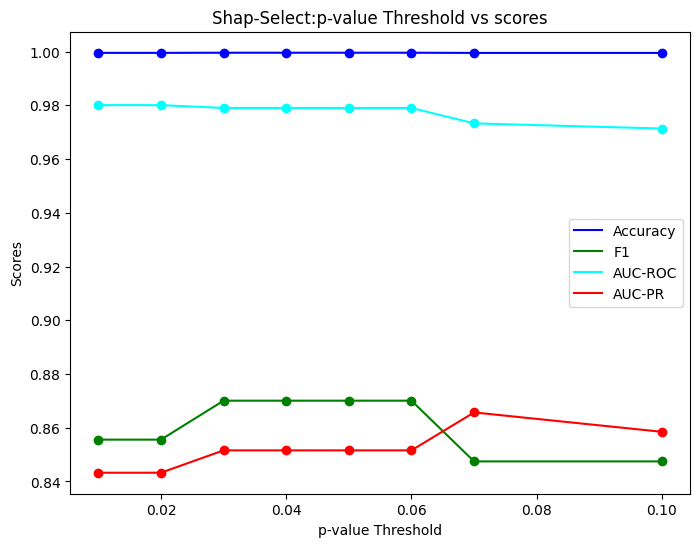

In [5]:

# Plot F1 Score vs p-value for Shapley Select
plt.figure(figsize=(8, 6))
cols = ["Accuracy","F1","AUC-ROC","AUC-PR"]
colors=["blue", "green", "cyan", "red"]
for col, color in zip(cols, colors):
    plt.scatter(scores["p-value"], scores[col], color=color)
    plt.plot(scores["p-value"], scores[col], linestyle='-', color=color, label=col)
plt.xlabel("p-value Threshold")
plt.ylabel("Scores")
plt.legend()
plt.title("Shap-Select:p-value Threshold vs scores")
plt.savefig("shapely_select_p_value_benchmarks.png")
print("Saved plot for Shapley Select p-value benchmarking.")
plt.show()